## Imports

In [24]:
import os
import cv2
import glob
import time
import torch
import pickle
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Folders & Loading

In [25]:
# Define folder paths
RAD_folder_path = '/home/hawk/Desktop/raddet data creator/data/RAD'
stereo_folder_path = '/home/hawk/Desktop/raddet data creator/data/stereo'
GT_folder_path = '/home/hawk/Desktop/raddet data creator/data/GT'

# Numpy files
all_RAD_files = os.listdir(RAD_folder_path)
RAD_files = [file for file in all_RAD_files if file.endswith('.npy')]
RAD_files_paths = [os.path.join(RAD_folder_path, file) for file in RAD_files]

# Ground truth files
all_GT_files = os.listdir(GT_folder_path)
GT_files = [file for file in all_GT_files if file.endswith('.pickle')]
GT_files_paths = [os.path.join(GT_folder_path, file) for file in all_GT_files]

# Stereo image files
all_stereo_files = os.listdir(stereo_folder_path)
stereo_files = [file for file in all_stereo_files if file.endswith('.jpg')]
stereo_files_paths = [os.path.join(stereo_folder_path, file) for file in all_stereo_files]

# For 2D & 3D views
random_samples = random.sample(RAD_files_paths, 1)

# Eric's checkpoints paths
checkpoint_paths = ['/home/hawk/Desktop/hawk-radar files/person_basemodel_resnet18.pth',
                    '/home/hawk/Desktop/hawk-radar files/truck_basemodel_resnet18.pth', 
                    '/home/hawk/Desktop/hawk-radar files/car_basemodel_resnet18.pth',
                    '/home/hawk/Desktop/hawk-radar files/bicycle_model_resnet18.pth' ]

### Numpy - RAD

In [26]:
all_loaded_RAD_files = []
for file in RAD_files_paths:
    loaded_file = np.load(file)
    all_loaded_RAD_files.append(loaded_file)
print(f'number of RAD files loaded: {len(all_loaded_RAD_files)}')
print(f'each RAD file is of size: {all_loaded_RAD_files[0].shape} which stands for: (Range, Azimuth, Doppler)')

number of RAD files loaded: 1000
each RAD file is of size: (256, 256, 64) which stands for: (Range, Azimuth, Doppler)


### Pickle - Ground Truth

In [27]:
all_loaded_GT_files = []
for file in GT_files_paths:
    with open(file, 'rb') as f:  
        ground_truth = pickle.load(f) 
    all_loaded_GT_files.append(ground_truth)
print(f'number of GT files loaded: {len(all_loaded_GT_files)}')
print(f'each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:')
print(all_loaded_GT_files[0])

number of GT files loaded: 1000
each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:
{'classes': ['car', 'truck'], 'boxes': array([[166.5,  88. ,  41.5,  24. ,  27. ,  12. ],
       [ 93. , 164. ,  13. ,  27. ,  11. ,  17. ]]), 'cart_boxes': array([[171.5, 227.5,  26. ,  18. ],
       [ 99.5, 299.5,  28. ,  14. ]])}


### jpg - Camera Images

In [28]:
all_loaded_stereo_files = []
for jpg_file in stereo_files_paths:
    img = Image.open(jpg_file)
    img = img.convert('RGB')
    all_loaded_stereo_files.append(img)
print(f"Number of loaded images: {len(all_loaded_stereo_files)}")

Number of loaded images: 1000


## visualization

### Range-Doppler maps in different azimuths

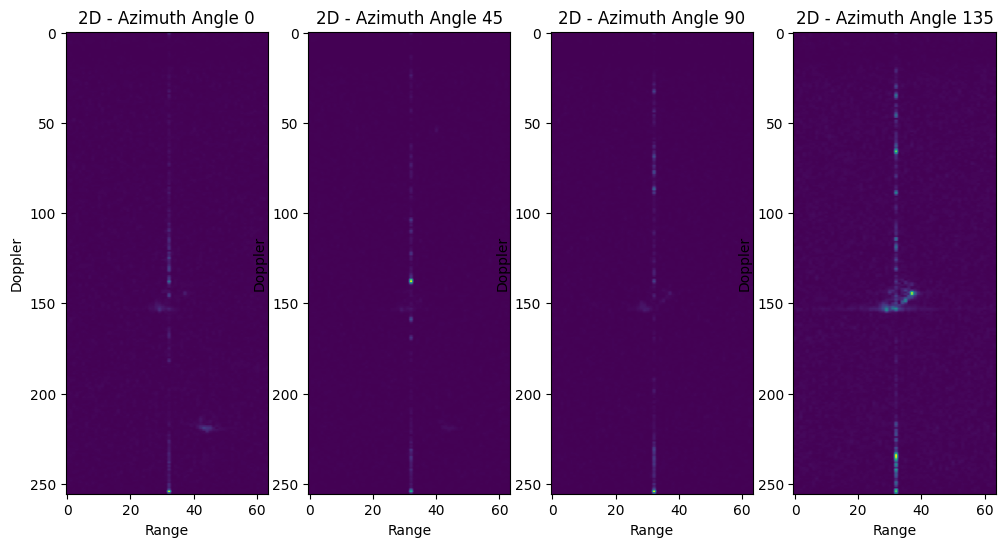

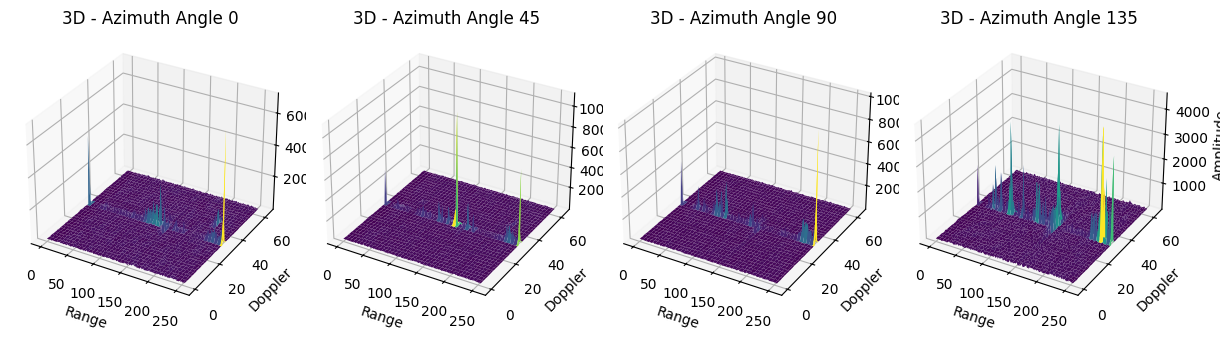

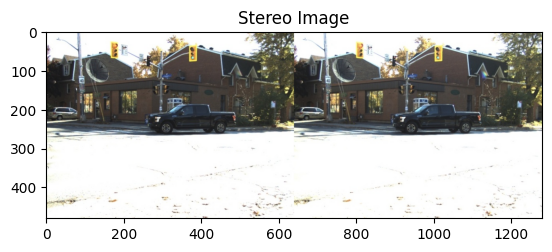

<Figure size 640x480 with 0 Axes>

In [29]:
azimuth_angles = [0, 45, 90, 135]
num_cols = 4
num_rows = (len(azimuth_angles) + num_cols - 1) // num_cols
for i, file_name in enumerate(random_samples):
    radar_data = np.load(file_name)
    fig2d = plt.figure(figsize=(12, 6))
    fig3d = plt.figure(figsize=(12, 6))

    for j, azimuth_angle in enumerate(azimuth_angles):
        row = j // num_cols
        col = j % num_cols

        range_doppler_plane = np.abs(radar_data[:, azimuth_angle, :])

        ax2d = fig2d.add_subplot(num_rows, num_cols, j + 1)
        ax2d.imshow(range_doppler_plane, cmap='viridis', aspect='auto')
        ax2d.set_title(f'2D - Azimuth Angle {azimuth_angle}')
        ax2d.set_xlabel('Range')
        ax2d.set_ylabel('Doppler')

        ax3d = fig3d.add_subplot(num_rows, num_cols, j + 1, projection='3d')
        range_indices, doppler_indices = np.meshgrid(np.arange(256), np.arange(64))
        ax3d.plot_surface(range_indices, doppler_indices, range_doppler_plane.T, cmap='viridis')
        ax3d.set_title(f'3D - Azimuth Angle {azimuth_angle}')
        ax3d.set_xlabel('Range')
        ax3d.set_ylabel('Doppler')
        ax3d.set_zlabel('Amplitude')

    plt.tight_layout()

    stereo_image_name = os.path.basename(file_name).replace('.npy', '.jpg')
    stereo_image_path = os.path.join(stereo_folder_path, stereo_image_name)
    stereo_image = cv2.imread(stereo_image_path)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(stereo_image, cv2.COLOR_BGR2RGB))
    plt.title('Stereo Image')
    
    plt.figure()
    plt.show()


### Range-Azimuth maps in different dopplers

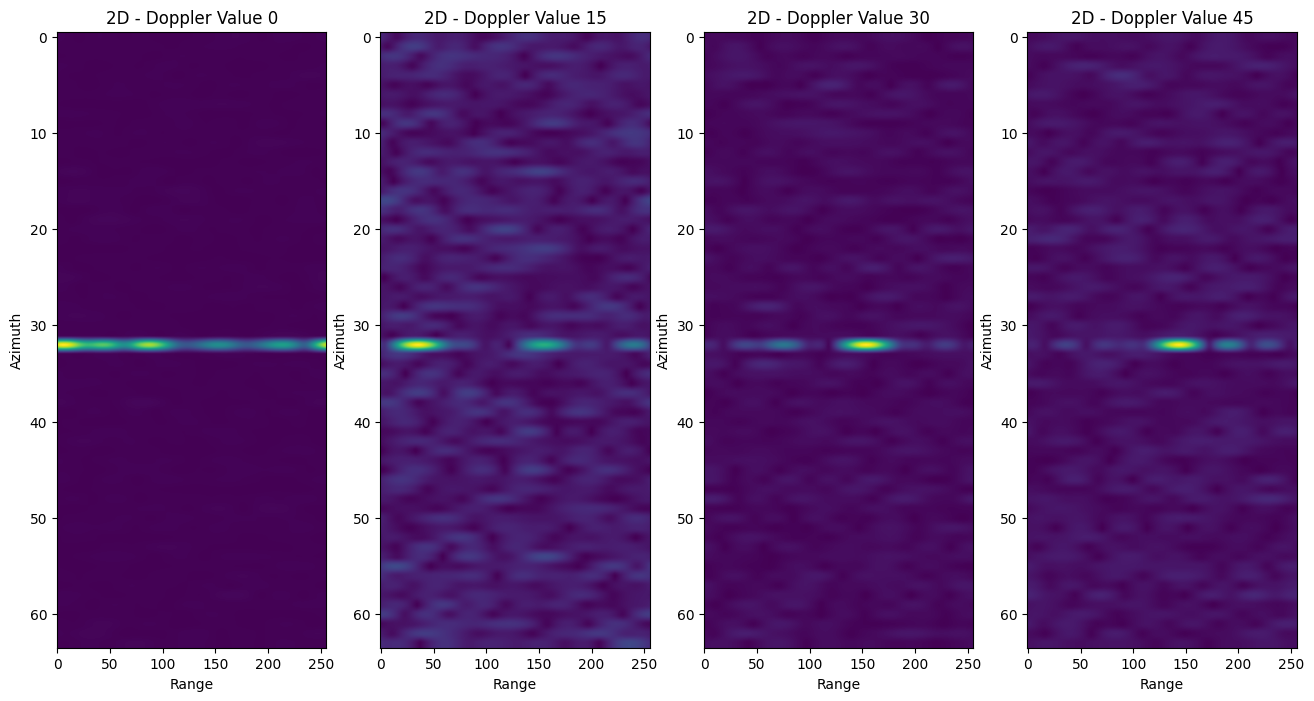

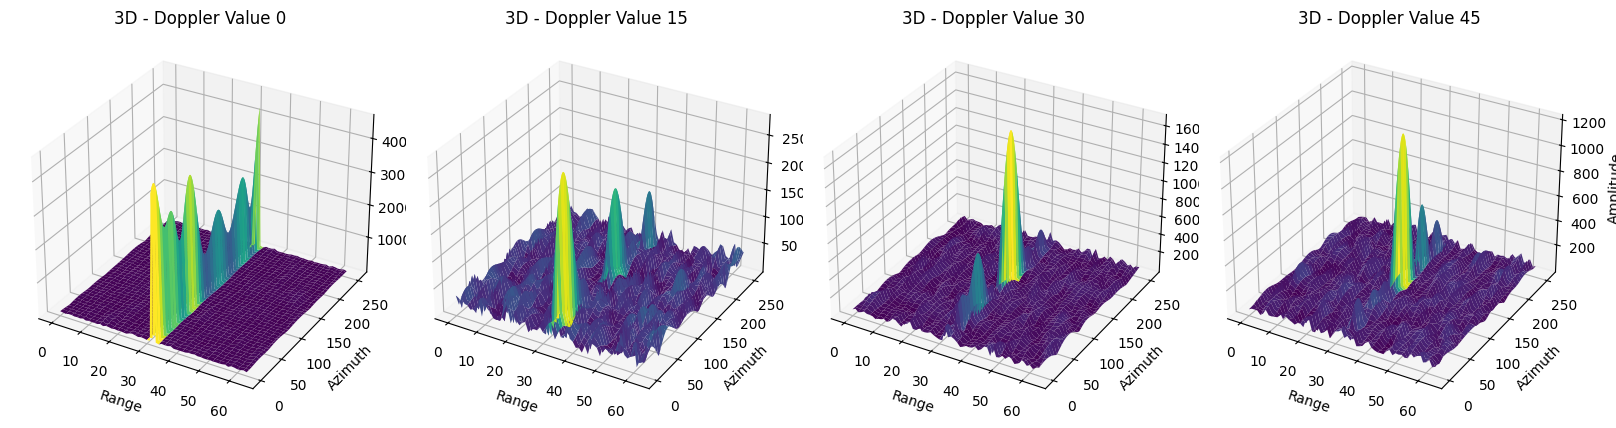

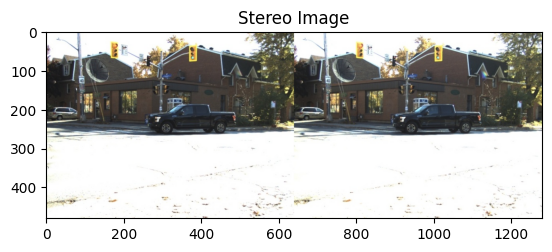

In [30]:
doppler_values = [0, 15, 30, 45]  
num_cols = 4
num_rows = (len(doppler_values) + num_cols - 1) // num_cols

for file_name in random_samples:
    radar_data = np.load(file_name)
    
    fig2d = plt.figure(figsize=(16, 8))
    fig3d = plt.figure(figsize=(16, 8))

    for i, doppler_value in enumerate(doppler_values):
        range_azimuth_plane = np.abs(radar_data[doppler_value, :, :]).T

        ax2d = fig2d.add_subplot(num_rows, num_cols, i + 1)
        ax2d.imshow(range_azimuth_plane, cmap='viridis', aspect='auto')
        ax2d.set_title(f'2D - Doppler Value {doppler_value}')
        ax2d.set_xlabel('Range')
        ax2d.set_ylabel('Azimuth')

        ax3d = fig3d.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        azimuth_indices, range_indices = np.meshgrid(np.arange(range_azimuth_plane.shape[1]), 
                                                     np.arange(range_azimuth_plane.shape[0]))
        ax3d.plot_surface(range_indices, azimuth_indices, range_azimuth_plane, cmap='viridis')
        ax3d.set_title(f'3D - Doppler Value {doppler_value}')
        ax3d.set_xlabel('Range')
        ax3d.set_ylabel('Azimuth')
        ax3d.set_zlabel('Amplitude')

    plt.tight_layout()
    stereo_image_name = os.path.basename(file_name).replace('.npy', '.jpg')
    stereo_image_path = os.path.join(stereo_folder_path, stereo_image_name)
    stereo_image = cv2.imread(stereo_image_path)
    
    plt.figure()
    plt.imshow(cv2.cvtColor(stereo_image, cv2.COLOR_BGR2RGB))
    plt.title('Stereo Image')
    plt.show()


## Preprocessing

### sort and arrange to a list of tensors

In [31]:
valid_maps = []
for file in all_loaded_RAD_files:
    # We only take 3 azimuths as channels
    reduced_map = file[:, [0,127,255], :]
    abs_maps = np.abs(reduced_map)
    reduced_map_transposed = np.transpose(abs_maps, axes=(2, 0, 1))
    valid_maps.append(reduced_map_transposed)
print(len(valid_maps))
print(valid_maps[0].shape)

1000
(64, 256, 3)


### obtain min and max values for normalization

In [32]:
maxs = -np.inf
mins = np.inf
for i in range(len(valid_maps)):
    maxes = np.max(valid_maps[i])
    mines = np.min(valid_maps[i])
    if maxes > maxs:
        maxs = maxes
    if mines < mins:
        mins = mines
normalized_data = [(tensor.astype(np.float32) - mins) / (maxs - mins) for tensor in valid_maps]
print(len(normalized_data))
print(normalized_data[2].shape)

1000
(64, 256, 3)


### create one hot vectors from labels

In [33]:
classes = ["person", "car", "truck", "motorcycle", "bicycle", "bus"]
num_classes = len(classes)
processed_ground_truth = []
for annotation in all_loaded_GT_files:
    labels = annotation['classes']
    labels_tensor = torch.zeros(num_classes, dtype=torch.float32) 
    for label in labels:
        label_index = classes.index(label)
        labels_tensor[label_index] = 1  

    boxes_tensor = torch.tensor(annotation['boxes'], dtype=torch.float32)
    cart_boxes_tensor = torch.tensor(annotation['cart_boxes'], dtype=torch.float32)
    processed_annotation = {'labels': labels_tensor, 'boxes': boxes_tensor, 'cart_boxes': cart_boxes_tensor}
    processed_ground_truth.append(processed_annotation)
print(type(processed_ground_truth), (len(processed_ground_truth)), type(processed_ground_truth[0]), len(processed_ground_truth[0]))
print(processed_ground_truth[0])

<class 'list'> 1000 <class 'dict'> 3
{'labels': tensor([0., 1., 1., 0., 0., 0.]), 'boxes': tensor([[166.5000,  88.0000,  41.5000,  24.0000,  27.0000,  12.0000],
        [ 93.0000, 164.0000,  13.0000,  27.0000,  11.0000,  17.0000]]), 'cart_boxes': tensor([[171.5000, 227.5000,  26.0000,  18.0000],
        [ 99.5000, 299.5000,  28.0000,  14.0000]])}


## RD DataLoader

In [34]:
class RDLoader(Dataset):
    def __init__(self, rd_dir, gt_dir):
        """
        Args:
            rd_dir: the directory containing the numpy rd maps
            gt_dir: the directory containing the ground truth dicts
        """
        
        #### RD maps handling ####
        # get rd maps names
        self.rd_dir = rd_dir
        self.rd_file_names = [f for f in os.listdir(rd_dir) if f.endswith('.npy')]
        '''
        for each range doppler map: 
        1. load it. 
        2. take 3 out of the 256 range-azimuth maps
        3. re-arange the tensor to 64,256,3 to fit the resnet.
        4. normalize it
        '''
        maxs = -np.inf
        mins = np.inf
        self.rd_maps = []
        for rd_name in self.rd_file_names:
            rd_path = os.path.join(self.rd_dir, rd_name)
            if not os.path.exists(rd_path):
                raise FileNotFoundError(f"RD file {rd_path} not found.")
            rd_map = np.load(rd_path)
            reduced_map = rd_map[:, [0,127,255], :]
            abs_maps = np.abs(reduced_map)
            reduced_map_transposed = np.transpose(abs_maps, axes=(1, 0, 2))
            maxes = np.max(reduced_map_transposed)
            mines = np.min(reduced_map_transposed)
            if maxes > maxs:
                maxs = maxes
            if mines < mins:
                mins = mines
            reduced_map_transposed = torch.from_numpy(reduced_map_transposed).float()
            self.rd_maps.append(reduced_map_transposed)
        self.normalized_rd_maps = [(tensor - mins) / (maxs - mins) for tensor in self.rd_maps]
        #### ground truth handling ####
        # get gt names
        self.gt_dir = gt_dir
        self.gt_file_names = [g for g in os.listdir(gt_dir) if g.endswith('.pickle')]
        gt_paths = [os.path.join(self.gt_dir, file) for file in self.gt_file_names]
        # for each gt file we turn the labels into a one-hot vector and turn other values to torch
        ground_truth_files = []
        for gt in gt_paths:
            with open(gt, 'rb') as f:  
                ground_truth = pickle.load(f) 
            ground_truth_files.append(ground_truth)
        classes = ["person", "car", "truck", "motorcycle", "bicycle", "bus"]
        num_classes = len(classes)
        self.processed_ground_truth = []
        for annotation in ground_truth_files:
            labels = annotation['classes']
            labels_tensor = torch.zeros(num_classes, dtype=torch.float32) 
            for label in labels:
                label_index = classes.index(label)
                labels_tensor[label_index] = 1  

            boxes_tensor = torch.tensor(annotation['boxes'], dtype=torch.float32)
            cart_boxes_tensor = torch.tensor(annotation['cart_boxes'], dtype=torch.float32)
            processed_annotation = {'labels': labels_tensor, 'boxes': boxes_tensor, 'cart_boxes': cart_boxes_tensor}
            self.processed_ground_truth.append(processed_annotation)


    def __len__(self):
        return len(self.rd_file_names)
    
    def __getitem__(self, index):
        '''
        Args:
            index = index of the item to return
        
        Returns:
            A tuple containing the normalized RD map and its corresponding ground truth
        '''
        rd_map = self.normalized_rd_maps[index]
        processed_gt = self.processed_ground_truth[index]

        return rd_map, processed_gt['labels']


### fix inconsistent tensors

In [35]:
def collate(batch):
    inputs, labels = zip(*batch)  
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0.0)
    labels_stacked = torch.stack(labels, dim=0)
    return inputs_padded, labels_stacked

## Train from scratch

In [36]:
model = models.resnet18(pretrained=False)
num_classes = 6  
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10  
dataset = RDLoader(RAD_folder_path, GT_folder_path)
dataloader = DataLoader(dataset, batch_size=4, collate_fn=collate)
test_dataset = RDLoader(RAD_folder_path, GT_folder_path)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate)  # Adjust batch_size as needed

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    total_correct = 0
    total_labels = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5  
        total_correct += (preds == labels).sum().item()
        total_labels += labels.numel()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = total_correct / total_labels
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train-   Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    model.eval()  
    running_loss = 0.0
    total_correct = 0
    total_labels = 0
    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            test_preds = torch.sigmoid(outputs) > 0.5
            total_correct += (test_preds == labels).sum().item()
            total_labels += labels.numel()

    epoch_loss = running_loss / len(test_dataloader)
    epoch_acc = total_correct / total_labels
    print(f'Test-   Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10
Train-   Loss: 0.4046, Accuracy: 0.8020
Test-   Loss: 0.3899, Accuracy: 0.8135
Epoch 2/10
Train-   Loss: 0.3864, Accuracy: 0.8080
Test-   Loss: 0.4292, Accuracy: 0.7922
Epoch 3/10
Train-   Loss: 0.3822, Accuracy: 0.8102
Test-   Loss: 0.4081, Accuracy: 0.8042
Epoch 4/10
Train-   Loss: 0.3796, Accuracy: 0.8098
Test-   Loss: 0.3877, Accuracy: 0.8165
Epoch 5/10
Train-   Loss: 0.3773, Accuracy: 0.8103
Test-   Loss: 0.3815, Accuracy: 0.8180
Epoch 6/10
Train-   Loss: 0.3756, Accuracy: 0.8113
Test-   Loss: 0.3814, Accuracy: 0.8173
Epoch 7/10
Train-   Loss: 0.3738, Accuracy: 0.8138
Test-   Loss: 0.3780, Accuracy: 0.8185
Epoch 8/10
Train-   Loss: 0.3714, Accuracy: 0.8147
Test-   Loss: 0.3770, Accuracy: 0.8200
Epoch 9/10
Train-   Loss: 0.3692, Accuracy: 0.8158
Test-   Loss: 0.3760, Accuracy: 0.8198
Epoch 10/10
Train-   Loss: 0.3676, Accuracy: 0.8165
Test-   Loss: 0.3755, Accuracy: 0.8197


## Try Eric's checkpoints

In [37]:
num_classes = 5  
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
for checkpoint_path in checkpoint_paths:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    model.eval() 
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(probs, 1)
            
            if labels.ndim > 1: 
                _, labels = torch.max(labels, 1)  
            
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f'Accuracy: {accuracy*100:.2f}%')


Accuracy: 3.30%
Accuracy: 0.00%
Accuracy: 3.30%
Accuracy: 3.30%


## Eric's Preprocessing code

In [38]:
label_files = glob.glob("/home/hawk/Desktop/raddet data creator/test_data/GT/*.pickle")
RAD_files = glob.glob("/home/hawk/Desktop/raddet data creator/test_data/RAD/*.npy")
az_width_mean = 51
range_width_mean = 74 
dopp_width_mean = 51
## The values above were determined by calculating the mean and st dev for each class and using such values for the largest class.  These three number represent mean + st dev for each class.

def slice_rad_file(rad_file, az_left, az_right, range_top, range_bottom, dopp_left, dopp_right):
    ## This function takes a npy file path of the original RADDETR dataset npy tensor along with the 3D extraction boundaries from the original npy tensor.  It returns the final carved npy tensor of the shape (64, 256, 3) which contains signal power for exactly one instance per new npy tensor.
    start_RAD = time.time()
    RAD = np.load(rad_file)
    RAD = np.transpose(RAD, (1, 0, 2)) ## convert from RAD to ARD tensors
    if az_left < 0:
        az_left_boundary = 0
        az_pad_left = -az_left 
    else:
        az_left_boundary = az_left
        az_pad_left = 0
    if az_right > 255:
        az_right_boundary = 255
        az_pad_right = az_right - 255
    else:
        az_right_boundary = az_right
        az_pad_right = 0

    if dopp_left < 0:
        dopp_left_boundary = 0
        dopp_pad_left = 0 ## orig: -dopp_left
    else:
        dopp_left_boundary = dopp_left
        dopp_pad_left = dopp_left ## orig zero
    if dopp_right > 63:
        dopp_right_boundary = 64
        dopp_pad_right = 0  # orig: dopp_right - 63
    else:
        dopp_right_boundary = dopp_right
        dopp_pad_right = 64 - dopp_right    # orig: 0
    
    if range_top < 0:
        range_top_boundary = 0
        range_pad_top = 0 #orig: -range_top 
    else:
        range_top_boundary = range_top
        range_pad_top = range_top # orig: 0
    if range_bottom > 255:
        range_bottom_boundary = 256
        range_pad_bottom = 0  # orig: range_bottom - 255
    else:
        range_bottom_boundary = range_bottom
        range_pad_bottom = 256 - range_bottom # orig: 0

    RD_unpadded = RAD[az_left_boundary:az_right_boundary,range_top_boundary:range_bottom_boundary,dopp_left_boundary:dopp_right_boundary]
    RD_padded = np.pad(RD_unpadded, ((az_pad_left, az_pad_right), (range_pad_top,range_pad_bottom), (dopp_pad_left, dopp_pad_right)))
    if az_width_mean % 3 == 0:
        left_1, right_1 = 0, int(az_width_mean/3)
        left_2, right_2 = int(az_width_mean/3), int(2*az_width_mean/3)
        left_3, right_3 = int(2*az_width_mean/3), az_width_mean
    elif az_width_mean % 3 == 2:
        left_1, right_1 = 0, int(az_width_mean/3) + 1
        left_2, right_2 = int(az_width_mean/3) + 1, int(2*az_width_mean/3) 
        left_3, right_3 = int(2*az_width_mean/3), az_width_mean
    else:
        left_1, right_1 = 0, int(az_width_mean/3) 
        left_2, right_2 = int(az_width_mean/3), int(2*az_width_mean/3) + 1
        left_3, right_3 = int(2*az_width_mean/3) + 1, az_width_mean

    ## absolute value and square
    RD = np.abs(RD_padded)
    RD = pow(RD, 2)
    
    ## separate the three sections
    RD_1 = RD[left_1:right_1,:,:]
    RD_2 = RD[left_2:right_2,:,:]
    RD_3 = RD[left_3:right_3,:,:]
    
    ## sum each section to a single channel
    RD_1 = np.sum(RD_1, axis=0)
    RD_2 = np.sum(RD_2, axis=0)
    RD_3 = np.sum(RD_3, axis=0)

    ## log
    RD_1 = np.log10(RD_1 + 1)
    RD_2 = np.log10(RD_2 + 1)
    RD_3 = np.log10(RD_3 + 1)

    ## stack the three channels to a 3 channel tensor
    RD_3_channel = np.stack([RD_1, RD_2, RD_3], axis=0) 
    
    ## return the new RAD file
    return np.transpose(RD_3_channel, (2, 1, 0))


def get_label_data(label):
    ## This function takes a single label file (pickle file) path from the original RADDET dataset, loops through the object instances, and returns a list for each on the return line: obj_list is the list of class names, az_center_list is the list of all azimuth centers, and so forth.
    start_get_label = time.time()
    obj_list = []
    az_center_list, range_center_list, dopp_center_list = [], [], []
    az_width_list, range_width_list, dopp_width_list = [], [], []
    data = pickle.load(open(label, 'rb'))
    for obj_num, obj in enumerate(data['classes']):
        obj_list.append(obj)
        az_center_list.append(data['boxes'][obj_num][1])
        az_width_list.append(data['boxes'][obj_num][3])
        range_center_list.append(data['boxes'][obj_num][0])
        range_width_list.append(data['boxes'][obj_num][3])
        dopp_center_list.append(data['boxes'][obj_num][2])
        dopp_width_list.append(data['boxes'][obj_num][5])
    return obj_list, az_center_list, az_width_list, range_center_list, range_width_list, dopp_center_list, dopp_width_list


dest_image_dir = "/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/test/images"
dest_labels_dir = "/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/test/labels"
## Make sure to change these to your local directories

class_labels = {"person":0, "bicycle":1, "car":2, "motorcycle":3, "bus":4, "truck":5}
global_class_count = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
az_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
range_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
dopp_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
az_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
range_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
dopp_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
az_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
range_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
dopp_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
new_sample_count = 0
for label_file in tqdm(sorted(label_files)):
    part, label_base = label_file.split('/')[-2:]
    image_name = "/home/hawk/Desktop/raddet data creator/test_data/RAD/" + label_base.split('.')[0] + ".npy"
    class_count = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
    obj_list, az_cent, az_width, range_cent, range_width, dopp_cent, dopp_width = get_label_data(label_file)
    for i, obj in enumerate(obj_list):
        class_count[obj] += 1
        global_class_count[obj] += 1
        #az_running_width[obj].append(az_width[i]) ## these lines only needed for computing mean and stdev for all channels.
        #range_running_width[obj].append(range_width[i])
        #dopp_running_width[obj].append(dopp_width[i])
    
        if (az_cent[i] + az_width_mean/2) % 1 == 0:
            az_left = int(az_cent[i] - az_width_mean/2)
            az_right = int(az_cent[i] + az_width_mean/2)
        else:
            az_left = int(az_cent[i] +.5 - az_width_mean/2)
            az_right = int(az_cent[i] + .5 + az_width_mean/2)

        if (range_cent[i] + range_width_mean/2) % 1 == 0:
            range_top = int(range_cent[i] - range_width_mean/2)
            range_bottom = int(range_cent[i] + range_width_mean/2)
        else:
            range_top = int(range_cent[i] +.5 - range_width_mean/2)
            range_bottom = int(range_cent[i] + .5 + range_width_mean/2)
        
        if (dopp_cent[i] + dopp_width_mean/2) % 1 == 0:
            dopp_left = int(dopp_cent[i] - dopp_width_mean/2)
            dopp_right = int(dopp_cent[i] + dopp_width_mean/2)
        else:
            dopp_left = int(dopp_cent[i] +.5 - dopp_width_mean/2)
            dopp_right = int(dopp_cent[i] + .5 + dopp_width_mean/2)

        RAD_3_ch = slice_rad_file(image_name,int(az_left), int(az_right), int(range_top), int(range_bottom), int(dopp_left), int(dopp_right))
        new_RAD_file_name = label_base.split(".")[0] + "_" + obj + "_" + str(class_count[obj]) + ".npy"
        total_new_file_name = os.path.join(dest_image_dir, new_RAD_file_name)
        
        new_label_name = label_base.split(".")[0] + "_" + obj + "_" + str(class_count[obj]) + ".txt"
        total_new_label_file_name = os.path.join(dest_labels_dir, new_label_name)
        label_line = " ".join([str(class_labels[obj]),str(int(dopp_cent[i])), str(int(range_cent[i])), str(int(dopp_width[i])), str(int(range_width[i]))])
        new_sample_count += 1
        if new_sample_count % 100 == 0: print(f"Sample Count: {new_sample_count}")
        with open(total_new_label_file_name, 'w') as f:
            f.write(label_line)
        
        with open(total_new_file_name, 'wb') as f:
            np.save(f, RAD_3_ch)

100%|██████████| 32/32 [00:00<00:00, 37.22it/s]


## Visualize outputs (after Eric's preprocessing)

Selected .npy files: ['/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/train/images/009081_person_1.npy']



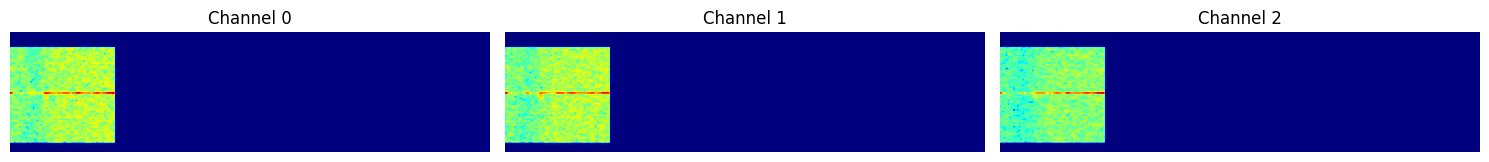

In [48]:
npfiles = glob.glob("/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/train/images/*.npy")
selected_files = random.sample(npfiles, 1)
print("Selected .npy files:", selected_files)
see_res = np.load(selected_files[0])
print()
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
titles = ['Channel 0', 'Channel 1', 'Channel 2']
for i in range(3):
    axs[i].imshow(see_res[:, :, i], cmap='jet') 
    axs[i].set_title(titles[i]) 
    axs[i].axis('off') 

plt.tight_layout()
plt.show()

## try checkpoints again

In [40]:
label_files = glob.glob("/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/train/labels/*.txt")
def extract_first_number(file_path):
    with open(file_path, 'r') as file:
        content = file.readline().strip()
        first_number = int(content.split()[0])
    return first_number

labels = [extract_first_number(file) for file in label_files]
inputs_paths = glob.glob("/home/hawk/Desktop/raddet data creator/radar_derivative_cropped/train/images/*.npy")

class ericLoader(Dataset):
    def __init__(self, inputs_paths, labels):
        self.inputs_paths = inputs_paths
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_path = self.inputs_paths[idx]
        input = np.load(input_path)
        input = np.transpose(input, (2, 0, 1))
        input = torch.tensor(input, dtype=torch.float32)
        label = self.labels[idx]
        return input, label

dataset = ericLoader(inputs_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False) 
for i, path in enumerate(checkpoint_paths):
    filename = path.split('/')[-1]
    name = filename.split('_')[0]
    print(f'{name} checkpoint:')
    checkpoint = torch.load(checkpoint_paths[i])
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    model.eval() 
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(probs, 1)
            
            if labels.ndim > 1: 
                _, labels = torch.max(labels, 1)  
            
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    print(f'Accuracy: {accuracy*100:.2f}%')


person checkpoint:
Accuracy: 58.12%
truck checkpoint:
Accuracy: 0.11%
car checkpoint:
Accuracy: 42.27%
bicycle checkpoint:
Accuracy: 44.74%


## Create indexes file for hawk

In [ ]:
def create_index_file_for_npy(directory, index_file_path):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    index_file_content = "\n".join([f"{path} 0" for path in file_paths])
    with open(index_file_path, "w") as index_file:
        index_file.write(index_file_content)
    print(f"Index file created at {index_file_path}")
directory = "/home/hawk/Desktop/scout-raddet/data/hawk/datasets/trainsplit/images/"
index_file_path = "/home/hawk/Desktop/scout-raddet/data/hawk/indexes/indexes.txt"
create_index_file_for_npy(directory, index_file_path)


Index file created at /home/hawk/Desktop/scout-raddet/data/hawk/indexes/indexes.txt
